# Monthly hotel-room occupancy — raw exploration
We have three parallel series (high-tariff A, high-tariff B, medium-tariff).
All rates are percentages, so we convert them to proportions (`0 - 1`).



In [1]:
# %% [parameters] ------------------------------------------------------------
"""
Configuration
-------------
Nothing else in the notebook should need editing – just keep these paths / names
up-to-date if you move the file or rename columns in the source CSV.
"""
import pathlib, os

ROOT = pathlib.Path(os.getcwd()).resolve().parent  # project root
DATA_FILE = ROOT / "examples" / "data" / "hotel_room_occupancy_rate_monthly_by_cat_en.csv"

DATE_COL = "Year-Month"  # YYYYMM integer / string
VALUE_COLS = [
    "Hotel room occupancy rate of high tariff A hotels",
    "Hotel room occupancy rate  of high tariff B hotels",
    "Hotel room occupancy rate of medium tariff hotels"
]

# %% -------------------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------- load & tidy ------------------------------------------------------
df = pd.read_csv(DATA_FILE)

# strip stray whitespace in *every* column name
df.columns = df.columns.str.strip()

# YYYYMM → pandas datetime (month-start index)
df["ds"] = pd.to_datetime(df[DATE_COL].astype(str), format="%Y%m", errors="raise")

# convert % → proportion
for col in VALUE_COLS:
    df[col] = df[col] / 100.0

# ensure all values are in the open interval (0,1)
if not ((df[VALUE_COLS] > 0) & (df[VALUE_COLS] < 1)).all().all():
    raise ValueError("Some occupancy rates fall outside (0, 1) – check the raw data!")

df = df.sort_values("ds").reset_index(drop=True)
display(df.head())

,Year-Month,Hotel room occupancy rate of high tariff A hotels,Hotel room occupancy rate of high tariff B hotels,Hotel room occupancy rate of medium tariff hotels,ds
0,202002,0.14,0.26,0.41,2020-02-01
1,202003,0.12,0.30,0.47,2020-03-01
2,202004,0.12,0.32,0.50,2020-04-01
3,202005,0.14,0.35,0.54,2020-05-01
4,202006,0.19,0.42,0.62,2020-06-01


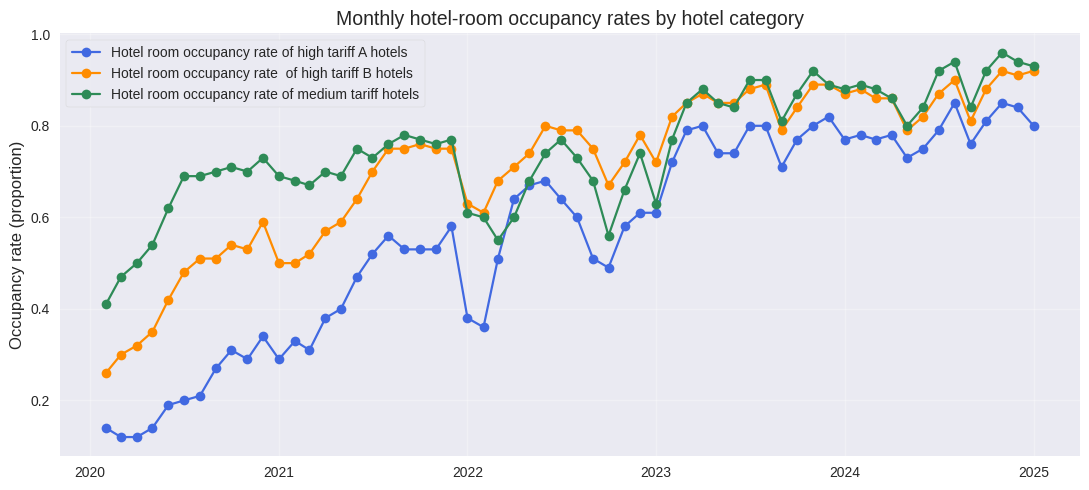

In [2]:

# --------- quick visual sanity-check ----------------------------------------
plt.style.use("seaborn-v0_8")
fig, ax = plt.subplots(figsize=(11, 5))  # Increased height for better visualization

col_colors = ["royalblue", "darkorange", "seagreen"]
for c, col in zip(col_colors, VALUE_COLS):
    ax.plot(df["ds"], df[col], marker="o", lw=1.6, label=col.strip(), color=c)

ax.set_ylabel("Occupancy rate (proportion)", fontsize=12)
ax.set_title("Monthly hotel-room occupancy rates by hotel category", fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(frameon=True, loc='best')
fig.tight_layout()

In [3]:

# %%  -------------------------------------------------------------------------
# Choose the "high-tariff A" series and set up cross-validation
# --------------------------------------------------------------------------
TARGET_COL = "Hotel room occupancy rate of high tariff A hotels"

series = (
    df[["ds", TARGET_COL]].rename(columns={TARGET_COL: "y"})
    .assign(t=np.arange(len(df), dtype=float))
)

t_all, y_all = series["t"].to_numpy(), series["y"].to_numpy()

# --- rolling-origin CV windows ---------------------------------------------
INIT_MONTHS = 24  # first 1½ years = training
CV_HORIZON = 12  # forecast 3 months ahead each fold
CV_STEP = 9  # slide by 3 months
HOLD_OUT_MO = 9  # keep last 6 months for a final test

first_test = INIT_MONTHS
fold_starts = list(range(first_test,
                         len(series) - HOLD_OUT_MO - CV_HORIZON + 1,
                         CV_STEP))
print(f"{len(series)} rows  →  {len(fold_starts)} CV folds")

60 rows  →  2 CV folds


In [4]:

# --- Optuna settings ---------------------------------------------------------
SEED = 42
TRIALS_MUR = 50
TRIALS_PROP = 30

import numpy as np

rmse = lambda a, f: np.sqrt(np.mean((a - f) ** 2))

# %%  -------------------------------------------------------------------------
# Hyper-parameter spaces, CV objective, Optuna search, hold-out fit
# --------------------------------------------------------------------------
import optuna, warnings, time
from prophet import Prophet
from murphet import fit_churn_model


/home/halsted/anaconda3/envs/murphet2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [5]:

# --- search spaces -----------------------------------------------------------
def mur_cfg(trial):
    periods, harms = [12.0], [trial.suggest_int("harm_year", 1, 4)]
    if trial.suggest_categorical("add_half", [0, 1]):
        periods.append(6.0)
        harms.append(trial.suggest_int("harm_half", 1, 3))

    return dict(
        periods=periods,
        num_harmonics=harms,
        n_changepoints=trial.suggest_int("n_cp", 2, 12),
        delta_scale=trial.suggest_float("delta_scale", 0.02, 0.8, log=True),
        gamma_scale=trial.suggest_float("gamma_scale", 1.0, 10.0),
        season_scale=trial.suggest_float("season_scale", 0.4, 2.5),
        # ρ prior is fixed inside the Stan file; beta_phi is learned there too
        likelihood="beta",
        inference="map",
        chains=2,
        iter=4000,
        warmup=0,
        seed=SEED,
    )


# --- Prophet search space ------------------------------------------------
def prop_cfg(trial):
    return dict(
        # Prophet's *built-in* yearly — we expose only its Fourier order:
        yearly_fourier=trial.suggest_int("yearly_fourier", 3, 10),

        # changepoint & seasonality priors
        cp_scale=trial.suggest_float("cp_scale", 0.01, 0.5, log=True),
        sea_scale=trial.suggest_float("sea_scale", 0.1, 10.0, log=True),
    )


# --- CV objective ------------------------------------------------------------
def cv_objective(build_cfg, is_murphet):
    def _obj(trial):
        cfg, errs = build_cfg(trial), []

        for idx in fold_starts:
            tr_end, te_end = idx, idx + CV_HORIZON
            try:
                if is_murphet:  # Murphet branch
                    m = fit_churn_model(t=t_all[:tr_end],
                                        y=y_all[:tr_end],
                                        **cfg)
                    pred = m.predict(t_all[tr_end:te_end])

                else:  # Prophet branch
                    p = Prophet(
                        changepoint_prior_scale=cfg["cp_scale"],
                        seasonality_prior_scale=cfg["sea_scale"],
                        yearly_seasonality=cfg["yearly_fourier"],  # <- one line!
                        weekly_seasonality=False,
                        daily_seasonality=False,
                    )

                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        p.fit(series.iloc[:tr_end][["ds", "y"]])

                    fut = p.make_future_dataframe(
                        CV_HORIZON, freq="MS").iloc[-CV_HORIZON:]
                    pred = p.predict(fut)["yhat"].to_numpy()

                errs.append(rmse(y_all[tr_end:te_end], pred))

            except RuntimeError:  # e.g. Stan or fitting failure
                return 1e6

        return float(np.mean(errs))

    return _obj


In [6]:

# --- search Murphet ----------------------------------------------------------
mur_study = optuna.create_study(direction="minimize",
                                sampler=optuna.samplers.TPESampler(seed=SEED))
mur_study.optimize(cv_objective(mur_cfg, True),
                   n_trials=TRIALS_MUR, show_progress_bar=True)
best_mur = mur_cfg(mur_study.best_trial)

[I 2025-04-21 00:28:04,921] A new study created in memory with name: no-name-029d4db6-0678-4140-a7af-a614bad650ea
Best trial: 0. Best value: 0.14278:   0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-04-21 00:28:04,954] Trial 0 finished with value: 0.1427803461894479 and parameters: {'harm_year': 2, 'add_half': 0, 'n_cp': 8, 'delta_scale': 0.03556159383830237, 'gamma_scale': 2.403950683025824, 'season_scale': 0.5219755855532189}. Best is trial 0 with value: 0.1427803461894479.


/home/halsted/Documents/python/murphet/src/murphet/churn_model.py:707: UserWarning: Optimization failed: Error during optimization! Command '/home/halsted/.murphet_models/murphet_beta_e00d90ac random seed=42 data file=/tmp/tmpbi9xfstf/yavpf1d9.json init=/tmp/tmpbi9xfstf/pp88d8u1.json output file=/tmp/tmpbi9xfstf/murphet_beta_e00d90acb6xuoy1d/murphet_beta_e00d90ac-20250421002805.csv method=optimize algorithm=lbfgs iter=10000' failed: console log output: [...].  Trying BFGS rescue.
  warnings.warn(
Best trial: 0. Best value: 0.14278:   4%|▍         | 2/50 [00:00<00:04, 11.11it/s]

[I 2025-04-21 00:28:05,101] Trial 1 finished with value: 0.20673316616354742 and parameters: {'harm_year': 4, 'add_half': 1, 'harm_half': 1, 'n_cp': 12, 'delta_scale': 0.43117447730995384, 'gamma_scale': 2.9110519961044856, 'season_scale': 0.7818324311349114}. Best is trial 0 with value: 0.1427803461894479.


/home/halsted/Documents/python/murphet/src/murphet/churn_model.py:707: UserWarning: Optimization failed: Error during optimization! Command '/home/halsted/.murphet_models/murphet_beta_e00d90ac random seed=42 data file=/tmp/tmpbi9xfstf/qknp8a6q.json init=/tmp/tmpbi9xfstf/5xesvyxo.json output file=/tmp/tmpbi9xfstf/murphet_beta_e00d90ac4sjodbts/murphet_beta_e00d90ac-20250421002805.csv method=optimize algorithm=lbfgs iter=10000' failed: console log output: [...].  Trying BFGS rescue.
  warnings.warn(
/home/halsted/Documents/python/murphet/src/murphet/churn_model.py:728: UserWarning: BFGS rescue also failed: Error during optimization! Command '/home/halsted/.murphet_models/murphet_beta_e00d90ac random seed=42 data file=/tmp/tmpbi9xfstf/rqtn2nrh.json init=/tmp/tmpbi9xfstf/pi1iklt0.json output file=/tmp/tmpbi9xfstf/murphet_beta_e00d90acaljlqbol/murphet_beta_e00d90ac-20250421002805.csv method=optimize algorithm=bfgs iter=5000' failed: console log output: [...].  Falling back to an even simpler

[I 2025-04-21 00:28:05,149] Trial 2 finished with value: 1000000.0 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 2, 'n_cp': 5, 'delta_scale': 0.19109751468217398, 'gamma_scale': 2.2554447458683766, 'season_scale': 1.0135037619239582}. Best is trial 0 with value: 0.1427803461894479.


/home/halsted/Documents/python/murphet/src/murphet/churn_model.py:707: UserWarning: Optimization failed: Error during optimization! Command '/home/halsted/.murphet_models/murphet_beta_e00d90ac random seed=42 data file=/tmp/tmpbi9xfstf/snu2junl.json init=/tmp/tmpbi9xfstf/xasqsu79.json output file=/tmp/tmpbi9xfstf/murphet_beta_e00d90acc_x4qjap/murphet_beta_e00d90ac-20250421002805.csv method=optimize algorithm=lbfgs iter=10000' failed: console log output: [...].  Trying BFGS rescue.
  warnings.warn(
/home/halsted/Documents/python/murphet/src/murphet/churn_model.py:728: UserWarning: BFGS rescue also failed: Error during optimization! Command '/home/halsted/.murphet_models/murphet_beta_e00d90ac random seed=42 data file=/tmp/tmpbi9xfstf/4xog9g3l.json init=/tmp/tmpbi9xfstf/bch84unu.json output file=/tmp/tmpbi9xfstf/murphet_beta_e00d90ac7owdsq0t/murphet_beta_e00d90ac-20250421002805.csv method=optimize algorithm=bfgs iter=5000' failed: console log output: [...].  Falling back to an even simpler

[I 2025-04-21 00:28:05,225] Trial 3 finished with value: 1000000.0 and parameters: {'harm_year': 2, 'add_half': 1, 'harm_half': 1, 'n_cp': 7, 'delta_scale': 0.17787449279672934, 'gamma_scale': 1.4180537144799796, 'season_scale': 1.6758441889930205}. Best is trial 0 with value: 0.1427803461894479.
[I 2025-04-21 00:28:05,246] Trial 4 finished with value: 0.10808710977518077 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 10, 'delta_scale': 0.06152328666462679, 'gamma_scale': 1.8790490260574548, 'season_scale': 1.8368893556755297}. Best is trial 4 with value: 0.10808710977518077.
[I 2025-04-21 00:28:05,284] Trial 5 finished with value: 0.1183156293128853 and parameters: {'harm_year': 2, 'add_half': 1, 'harm_half': 1, 'n_cp': 12, 'delta_scale': 0.05195305024387061, 'gamma_scale': 6.962700559185838, 'season_scale': 1.054593259787763}. Best is trial 4 with value: 0.10808710977518077.


/home/halsted/Documents/python/murphet/src/murphet/churn_model.py:707: UserWarning: Optimization failed: Error during optimization! Command '/home/halsted/.murphet_models/murphet_beta_e00d90ac random seed=42 data file=/tmp/tmpbi9xfstf/yknw6ovu.json init=/tmp/tmpbi9xfstf/xs8egh3c.json output file=/tmp/tmpbi9xfstf/murphet_beta_e00d90acwhppnb8u/murphet_beta_e00d90ac-20250421002805.csv method=optimize algorithm=lbfgs iter=10000' failed: console log output: [...].  Trying BFGS rescue.
  warnings.warn(
Best trial: 4. Best value: 0.108087:  24%|██▍       | 12/50 [00:00<00:01, 19.95it/s]

[I 2025-04-21 00:28:05,446] Trial 6 finished with value: 0.229636987247849 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 12, 'delta_scale': 0.3490111324600883, 'gamma_scale': 9.455490474077703, 'season_scale': 2.2791374358980625}. Best is trial 4 with value: 0.10808710977518077.
[I 2025-04-21 00:28:05,459] Trial 7 finished with value: 0.14615853499656706 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 4, 'delta_scale': 0.023631257130122117, 'gamma_scale': 3.927972976869379, 'season_scale': 1.2162223083479122}. Best is trial 4 with value: 0.10808710977518077.
[I 2025-04-21 00:28:05,516] Trial 8 finished with value: 0.2017942650981752 and parameters: {'harm_year': 2, 'add_half': 0, 'n_cp': 5, 'delta_scale': 0.1480681594456554, 'gamma_scale': 2.2683180247728636, 'season_scale': 2.0846136595834834}. Best is trial 4 with value: 0.10808710977518077.
[I 2025-04-21 00:28:05,527] Trial 9 finished with value: 0.1423560056331429 and parameters: {'harm_year': 1, 'add_half': 0, 'n

Best trial: 4. Best value: 0.108087:  28%|██▊       | 14/50 [00:00<00:01, 21.99it/s]/home/halsted/Documents/python/murphet/src/murphet/churn_model.py:707: UserWarning: Optimization failed: Error during optimization! Command '/home/halsted/.murphet_models/murphet_beta_e00d90ac random seed=42 data file=/tmp/tmpbi9xfstf/cop5_kix.json init=/tmp/tmpbi9xfstf/9afoiy6c.json output file=/tmp/tmpbi9xfstf/murphet_beta_e00d90ac7g1846hj/murphet_beta_e00d90ac-20250421002805.csv method=optimize algorithm=lbfgs iter=10000' failed: console log output: [...].  Trying BFGS rescue.
  warnings.warn(
/home/halsted/Documents/python/murphet/src/murphet/churn_model.py:728: UserWarning: BFGS rescue also failed: Error during optimization! Command '/home/halsted/.murphet_models/murphet_beta_e00d90ac random seed=42 data file=/tmp/tmpbi9xfstf/7zo_9_is.json init=/tmp/tmpbi9xfstf/710fd04e.json output file=/tmp/tmpbi9xfstf/murphet_beta_e00d90acvhh100f8/murphet_beta_e00d90ac-20250421002805.csv method=optimize algorithm

[I 2025-04-21 00:28:05,670] Trial 13 finished with value: 0.11176648887605263 and parameters: {'harm_year': 3, 'add_half': 1, 'harm_half': 1, 'n_cp': 10, 'delta_scale': 0.04359916669213326, 'gamma_scale': 5.653012128865023, 'season_scale': 1.8151147127750544}. Best is trial 4 with value: 0.10808710977518077.
[I 2025-04-21 00:28:05,813] Trial 14 finished with value: 1000000.0 and parameters: {'harm_year': 4, 'add_half': 1, 'harm_half': 2, 'n_cp': 9, 'delta_scale': 0.08761491444632406, 'gamma_scale': 4.802123999800077, 'season_scale': 1.8452819750954186}. Best is trial 4 with value: 0.10808710977518077.


Best trial: 4. Best value: 0.108087:  34%|███▍      | 17/50 [00:01<00:02, 15.81it/s]/home/halsted/Documents/python/murphet/src/murphet/churn_model.py:707: UserWarning: Optimization failed: Error during optimization! Command '/home/halsted/.murphet_models/murphet_beta_e00d90ac random seed=42 data file=/tmp/tmpbi9xfstf/7snx4g60.json init=/tmp/tmpbi9xfstf/r1vcs6pi.json output file=/tmp/tmpbi9xfstf/murphet_beta_e00d90acg2wfmyao/murphet_beta_e00d90ac-20250421002805.csv method=optimize algorithm=lbfgs iter=10000' failed: console log output: [...].  Trying BFGS rescue.
  warnings.warn(
/home/halsted/Documents/python/murphet/src/murphet/churn_model.py:728: UserWarning: BFGS rescue also failed: Error during optimization! Command '/home/halsted/.murphet_models/murphet_beta_e00d90ac random seed=42 data file=/tmp/tmpbi9xfstf/nyhsyu_6.json init=/tmp/tmpbi9xfstf/s6_ib59_.json output file=/tmp/tmpbi9xfstf/murphet_beta_e00d90acjnmq2d_k/murphet_beta_e00d90ac-20250421002805.csv method=optimize algorithm

[I 2025-04-21 00:28:05,934] Trial 15 finished with value: 0.2577843807185329 and parameters: {'harm_year': 3, 'add_half': 1, 'harm_half': 3, 'n_cp': 10, 'delta_scale': 0.7883316536325532, 'gamma_scale': 3.8395374177451407, 'season_scale': 2.0744469083547834}. Best is trial 4 with value: 0.10808710977518077.
[I 2025-04-21 00:28:05,964] Trial 16 finished with value: 0.11255910720097931 and parameters: {'harm_year': 3, 'add_half': 1, 'harm_half': 2, 'n_cp': 8, 'delta_scale': 0.040348439221669544, 'gamma_scale': 1.0299987749092168, 'season_scale': 1.67303312230974}. Best is trial 4 with value: 0.10808710977518077.
[I 2025-04-21 00:28:06,007] Trial 17 finished with value: 1000000.0 and parameters: {'harm_year': 4, 'add_half': 1, 'harm_half': 3, 'n_cp': 2, 'delta_scale': 0.1042151246192406, 'gamma_scale': 5.863134524868209, 'season_scale': 2.0579164163181716}. Best is trial 4 with value: 0.10808710977518077.
[I 2025-04-21 00:28:06,029] Trial 18 finished with value: 0.1537203605453184 and par

/home/halsted/Documents/python/murphet/src/murphet/churn_model.py:707: UserWarning: Optimization failed: Error during optimization! Command '/home/halsted/.murphet_models/murphet_beta_e00d90ac random seed=42 data file=/tmp/tmpbi9xfstf/uu6okqxm.json init=/tmp/tmpbi9xfstf/0n0d763r.json output file=/tmp/tmpbi9xfstf/murphet_beta_e00d90ac1pcj_5jw/murphet_beta_e00d90ac-20250421002806.csv method=optimize algorithm=lbfgs iter=10000' failed: console log output: [...].  Trying BFGS rescue.
  warnings.warn(
/home/halsted/Documents/python/murphet/src/murphet/churn_model.py:728: UserWarning: BFGS rescue also failed: Error during optimization! Command '/home/halsted/.murphet_models/murphet_beta_e00d90ac random seed=42 data file=/tmp/tmpbi9xfstf/u4ec4z9c.json init=/tmp/tmpbi9xfstf/oxqk6vao.json output file=/tmp/tmpbi9xfstf/murphet_beta_e00d90ac56fkxb9y/murphet_beta_e00d90ac-20250421002806.csv method=optimize algorithm=bfgs iter=5000' failed: console log output: [...].  Falling back to an even simpler

[I 2025-04-21 00:28:06,167] Trial 22 finished with value: 1000000.0 and parameters: {'harm_year': 3, 'add_half': 1, 'harm_half': 2, 'n_cp': 8, 'delta_scale': 0.10661575571616949, 'gamma_scale': 3.1767547711235418, 'season_scale': 1.6607086331883818}. Best is trial 4 with value: 0.10808710977518077.
[I 2025-04-21 00:28:06,189] Trial 23 finished with value: 0.1555945785902308 and parameters: {'harm_year': 3, 'add_half': 1, 'harm_half': 1, 'n_cp': 9, 'delta_scale': 0.03056810754190332, 'gamma_scale': 1.5854752024978351, 'season_scale': 1.3451404762502428}. Best is trial 4 with value: 0.10808710977518077.
[I 2025-04-21 00:28:06,222] Trial 24 finished with value: 0.12043670692563042 and parameters: {'harm_year': 2, 'add_half': 1, 'harm_half': 3, 'n_cp': 6, 'delta_scale': 0.049496501901418966, 'gamma_scale': 1.089770765123934, 'season_scale': 1.909353019913722}. Best is trial 4 with value: 0.10808710977518077.
[I 2025-04-21 00:28:06,304] Trial 25 finished with value: 0.14498808027374321 and 

[I 2025-04-21 00:28:06,377] Trial 27 finished with value: 0.11247476295905576 and parameters: {'harm_year': 2, 'add_half': 0, 'n_cp': 10, 'delta_scale': 0.04098260090580938, 'gamma_scale': 2.1023153249240036, 'season_scale': 1.4564913552234253}. Best is trial 4 with value: 0.10808710977518077.
[I 2025-04-21 00:28:06,398] Trial 28 finished with value: 0.14652288520610818 and parameters: {'harm_year': 1, 'add_half': 0, 'n_cp': 10, 'delta_scale': 0.027204531739335135, 'gamma_scale': 5.887894920910558, 'season_scale': 1.4772064167045196}. Best is trial 4 with value: 0.10808710977518077.
[I 2025-04-21 00:28:06,418] Trial 29 finished with value: 0.14131946553470875 and parameters: {'harm_year': 2, 'add_half': 0, 'n_cp': 11, 'delta_scale': 0.037721205013018684, 'gamma_scale': 3.4756604846927193, 'season_scale': 0.41936009389250195}. Best is trial 4 with value: 0.10808710977518077.
[I 2025-04-21 00:28:06,465] Trial 30 finished with value: 0.1479434850391546 and parameters: {'harm_year': 2, 'ad

Best trial: 4. Best value: 0.108087:  70%|███████   | 35/50 [00:01<00:00, 27.17it/s]/home/halsted/Documents/python/murphet/src/murphet/churn_model.py:707: UserWarning: Optimization failed: Error during optimization! Command '/home/halsted/.murphet_models/murphet_beta_e00d90ac random seed=42 data file=/tmp/tmpbi9xfstf/i6pl05bz.json init=/tmp/tmpbi9xfstf/16a08ed2.json output file=/tmp/tmpbi9xfstf/murphet_beta_e00d90acql_7gb5o/murphet_beta_e00d90ac-20250421002806.csv method=optimize algorithm=lbfgs iter=10000' failed: console log output: [...].  Trying BFGS rescue.
  warnings.warn(
Best trial: 4. Best value: 0.108087:  76%|███████▌  | 38/50 [00:01<00:00, 25.20it/s]

[I 2025-04-21 00:28:06,600] Trial 35 finished with value: 0.16096503896232836 and parameters: {'harm_year': 2, 'add_half': 1, 'harm_half': 2, 'n_cp': 8, 'delta_scale': 0.021423041605262115, 'gamma_scale': 1.062700241432372, 'season_scale': 1.762223758309245}. Best is trial 4 with value: 0.10808710977518077.
[I 2025-04-21 00:28:06,701] Trial 36 finished with value: 0.19769545112032594 and parameters: {'harm_year': 2, 'add_half': 1, 'harm_half': 3, 'n_cp': 6, 'delta_scale': 0.21201493645112107, 'gamma_scale': 4.466806700147156, 'season_scale': 1.9922208191951998}. Best is trial 4 with value: 0.10808710977518077.
[I 2025-04-21 00:28:06,720] Trial 37 finished with value: 0.1452404172227182 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 11, 'delta_scale': 0.03889015436725984, 'gamma_scale': 5.385946176503635, 'season_scale': 1.181095720956519}. Best is trial 4 with value: 0.10808710977518077.


/home/halsted/Documents/python/murphet/src/murphet/churn_model.py:707: UserWarning: Optimization failed: Error during optimization! Command '/home/halsted/.murphet_models/murphet_beta_e00d90ac random seed=42 data file=/tmp/tmpbi9xfstf/q5hya6xw.json init=/tmp/tmpbi9xfstf/_igckn99.json output file=/tmp/tmpbi9xfstf/murphet_beta_e00d90ac65yz0n_0/murphet_beta_e00d90ac-20250421002806.csv method=optimize algorithm=lbfgs iter=10000' failed: console log output: [...].  Trying BFGS rescue.
  warnings.warn(
Best trial: 43. Best value: 0.104595:  90%|█████████ | 45/50 [00:02<00:00, 24.46it/s]

[I 2025-04-21 00:28:06,841] Trial 38 finished with value: 0.1972070097414911 and parameters: {'harm_year': 4, 'add_half': 1, 'harm_half': 2, 'n_cp': 8, 'delta_scale': 0.25377924849464606, 'gamma_scale': 3.1771519892298166, 'season_scale': 2.4963955309486074}. Best is trial 4 with value: 0.10808710977518077.
[I 2025-04-21 00:28:06,864] Trial 39 finished with value: 0.14268436555086428 and parameters: {'harm_year': 1, 'add_half': 0, 'n_cp': 12, 'delta_scale': 0.027605888782507318, 'gamma_scale': 2.139241683620612, 'season_scale': 0.8764191813525576}. Best is trial 4 with value: 0.10808710977518077.
[I 2025-04-21 00:28:06,891] Trial 40 finished with value: 0.11276866921393283 and parameters: {'harm_year': 2, 'add_half': 1, 'harm_half': 2, 'n_cp': 10, 'delta_scale': 0.04874975286925226, 'gamma_scale': 6.408085812851635, 'season_scale': 1.7915278886953387}. Best is trial 4 with value: 0.10808710977518077.
[I 2025-04-21 00:28:06,913] Trial 41 finished with value: 0.14313013005202427 and para

Best trial: 43. Best value: 0.104595: 100%|██████████| 50/50 [00:02<00:00, 21.23it/s]

[I 2025-04-21 00:28:07,084] Trial 45 finished with value: 0.14543924167024852 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 10, 'delta_scale': 0.14488858335731652, 'gamma_scale': 9.818607442594255, 'season_scale': 1.9678357166115255}. Best is trial 43 with value: 0.10459479440838879.
[I 2025-04-21 00:28:07,126] Trial 46 finished with value: 0.11038356667424107 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 6, 'delta_scale': 0.07666978932163467, 'gamma_scale': 7.892423209736344, 'season_scale': 2.2035467435527134}. Best is trial 43 with value: 0.10459479440838879.
[I 2025-04-21 00:28:07,154] Trial 47 finished with value: 0.11160187801397 and parameters: {'harm_year': 1, 'add_half': 0, 'n_cp': 5, 'delta_scale': 0.07795770472866773, 'gamma_scale': 8.670190226196341, 'season_scale': 1.2313628326606696}. Best is trial 43 with value: 0.10459479440838879.
[I 2025-04-21 00:28:07,187] Trial 48 finished with value: 0.111893135914596 and parameters: {'harm_year': 1, 'add_half':

In [7]:

# --- search Prophet ----------------------------------------------------------
prop_study = optuna.create_study(direction="minimize",
                                 sampler=optuna.samplers.TPESampler(seed=SEED))
prop_study.optimize(cv_objective(prop_cfg, False),
                    n_trials=TRIALS_PROP, show_progress_bar=True)
best_prop = prop_cfg(prop_study.best_trial)
# --- final fit on training window ------------------------------------------
train, test = series.iloc[:-HOLD_OUT_MO], series.iloc[-HOLD_OUT_MO:]

[I 2025-04-21 00:28:07,339] A new study created in memory with name: no-name-f2d65c41-8c38-4178-82f4-7907d0411074
Best trial: 1. Best value: 0.122215:   7%|▋         | 2/30 [00:00<00:04,  5.86it/s]

[I 2025-04-21 00:28:07,561] Trial 0 finished with value: 0.16987622596579313 and parameters: {'yearly_fourier': 5, 'cp_scale': 0.4123206532618726, 'sea_scale': 2.9106359131330697}. Best is trial 0 with value: 0.16987622596579313.
[I 2025-04-21 00:28:07,696] Trial 1 finished with value: 0.12221484378732392 and parameters: {'yearly_fourier': 7, 'cp_scale': 0.018410729205738687, 'sea_scale': 0.2051110418843398}. Best is trial 1 with value: 0.12221484378732392.


Best trial: 1. Best value: 0.122215:  13%|█▎        | 4/30 [00:00<00:03,  6.88it/s]

[I 2025-04-21 00:28:07,866] Trial 2 finished with value: 0.14597482362597708 and parameters: {'yearly_fourier': 3, 'cp_scale': 0.29621516588303487, 'sea_scale': 1.5930522616241019}. Best is trial 1 with value: 0.12221484378732392.
[I 2025-04-21 00:28:07,973] Trial 3 finished with value: 0.13680697153746085 and parameters: {'yearly_fourier': 8, 'cp_scale': 0.01083858126934475, 'sea_scale': 8.706020878304859}. Best is trial 1 with value: 0.12221484378732392.


Best trial: 5. Best value: 0.115969:  17%|█▋        | 5/30 [00:00<00:03,  7.28it/s]

[I 2025-04-21 00:28:08,096] Trial 4 finished with value: 0.12301012094423597 and parameters: {'yearly_fourier': 9, 'cp_scale': 0.022948683681130556, 'sea_scale': 0.23102018878452935}. Best is trial 1 with value: 0.12221484378732392.
[I 2025-04-21 00:28:08,193] Trial 5 finished with value: 0.11596921232267754 and parameters: {'yearly_fourier': 4, 'cp_scale': 0.0328774741399112, 'sea_scale': 1.1207606211860568}. Best is trial 5 with value: 0.11596921232267754.


Best trial: 5. Best value: 0.115969:  27%|██▋       | 8/30 [00:01<00:02,  8.30it/s]

[I 2025-04-21 00:28:08,324] Trial 6 finished with value: 0.1254119056303786 and parameters: {'yearly_fourier': 6, 'cp_scale': 0.03124565071260872, 'sea_scale': 1.6738085788752133}. Best is trial 5 with value: 0.11596921232267754.
[I 2025-04-21 00:28:08,431] Trial 7 finished with value: 0.11601172334481535 and parameters: {'yearly_fourier': 4, 'cp_scale': 0.03135775732257745, 'sea_scale': 0.5404103854647329}. Best is trial 5 with value: 0.11596921232267754.


Best trial: 5. Best value: 0.115969:  33%|███▎      | 10/30 [00:01<00:02,  6.77it/s]

[I 2025-04-21 00:28:08,625] Trial 8 finished with value: 0.1359743166027902 and parameters: {'yearly_fourier': 6, 'cp_scale': 0.21576967455896826, 'sea_scale': 0.2508115686045233}. Best is trial 5 with value: 0.11596921232267754.
[I 2025-04-21 00:28:08,790] Trial 9 finished with value: 0.12252336843739552 and parameters: {'yearly_fourier': 7, 'cp_scale': 0.10150667045928574, 'sea_scale': 0.1238513729886093}. Best is trial 5 with value: 0.11596921232267754.


Best trial: 11. Best value: 0.113234:  40%|████      | 12/30 [00:01<00:02,  7.53it/s]

[I 2025-04-21 00:28:08,928] Trial 10 finished with value: 0.11329845181878766 and parameters: {'yearly_fourier': 3, 'cp_scale': 0.0637043254433697, 'sea_scale': 0.6199734532912116}. Best is trial 10 with value: 0.11329845181878766.
[I 2025-04-21 00:28:09,031] Trial 11 finished with value: 0.11323379702461775 and parameters: {'yearly_fourier': 3, 'cp_scale': 0.06501502479272445, 'sea_scale': 0.6678214571929402}. Best is trial 11 with value: 0.11323379702461775.


Best trial: 13. Best value: 0.111276:  47%|████▋     | 14/30 [00:01<00:02,  7.05it/s]

[I 2025-04-21 00:28:09,153] Trial 12 finished with value: 0.11312812145638801 and parameters: {'yearly_fourier': 3, 'cp_scale': 0.0719064967092868, 'sea_scale': 0.6036904056354223}. Best is trial 12 with value: 0.11312812145638801.
[I 2025-04-21 00:28:09,324] Trial 13 finished with value: 0.11127574990708425 and parameters: {'yearly_fourier': 10, 'cp_scale': 0.08958498826661347, 'sea_scale': 0.527256167708933}. Best is trial 13 with value: 0.11127574990708425.


Best trial: 13. Best value: 0.111276:  50%|█████     | 15/30 [00:07<00:25,  1.71s/it]

[I 2025-04-21 00:28:14,752] Trial 14 finished with value: 0.1118476418290448 and parameters: {'yearly_fourier': 10, 'cp_scale': 0.13223835601681144, 'sea_scale': 0.3996662608547175}. Best is trial 13 with value: 0.11127574990708425.


Best trial: 13. Best value: 0.111276:  53%|█████▎    | 16/30 [00:12<00:38,  2.78s/it]

[I 2025-04-21 00:28:20,036] Trial 15 finished with value: 0.15862674077750047 and parameters: {'yearly_fourier': 10, 'cp_scale': 0.14862885617791483, 'sea_scale': 0.40384940836815675}. Best is trial 13 with value: 0.11127574990708425.


Best trial: 17. Best value: 0.100546:  60%|██████    | 18/30 [00:18<00:30,  2.57s/it]

[I 2025-04-21 00:28:25,538] Trial 16 finished with value: 0.17458882910269585 and parameters: {'yearly_fourier': 10, 'cp_scale': 0.14169640056443364, 'sea_scale': 3.460931541920756}. Best is trial 13 with value: 0.11127574990708425.
[I 2025-04-21 00:28:25,730] Trial 17 finished with value: 0.10054604372458374 and parameters: {'yearly_fourier': 9, 'cp_scale': 0.10834234325942506, 'sea_scale': 0.3539728451056159}. Best is trial 17 with value: 0.10054604372458374.


Best trial: 17. Best value: 0.100546:  63%|██████▎   | 19/30 [00:18<00:20,  1.86s/it]

[I 2025-04-21 00:28:25,911] Trial 18 finished with value: 0.12149825158539017 and parameters: {'yearly_fourier': 9, 'cp_scale': 0.04955950546630037, 'sea_scale': 0.104446732715349}. Best is trial 17 with value: 0.10054604372458374.


Best trial: 17. Best value: 0.100546:  70%|███████   | 21/30 [00:23<00:18,  2.06s/it]

[I 2025-04-21 00:28:31,123] Trial 19 finished with value: 0.17496750536613562 and parameters: {'yearly_fourier': 9, 'cp_scale': 0.1970263374832058, 'sea_scale': 1.0417813052921943}. Best is trial 17 with value: 0.10054604372458374.
[I 2025-04-21 00:28:31,308] Trial 20 finished with value: 0.1012795912749345 and parameters: {'yearly_fourier': 8, 'cp_scale': 0.0984600875950469, 'sea_scale': 0.32750333549080435}. Best is trial 17 with value: 0.10054604372458374.


Best trial: 17. Best value: 0.100546:  77%|███████▋  | 23/30 [00:24<00:07,  1.10s/it]

[I 2025-04-21 00:28:31,487] Trial 21 finished with value: 0.1016046690440078 and parameters: {'yearly_fourier': 8, 'cp_scale': 0.09130467244534733, 'sea_scale': 0.34356146407557037}. Best is trial 17 with value: 0.10054604372458374.
[I 2025-04-21 00:28:31,661] Trial 22 finished with value: 0.12244253986676311 and parameters: {'yearly_fourier': 8, 'cp_scale': 0.047855767175242696, 'sea_scale': 0.17929275045049992}. Best is trial 17 with value: 0.10054604372458374.


Best trial: 23. Best value: 0.0981233:  80%|████████  | 24/30 [00:24<00:04,  1.21it/s]

[I 2025-04-21 00:28:31,844] Trial 23 finished with value: 0.09812326507273858 and parameters: {'yearly_fourier': 8, 'cp_scale': 0.10915581564683427, 'sea_scale': 0.3269464086983182}. Best is trial 23 with value: 0.09812326507273858.


Best trial: 23. Best value: 0.0981233:  83%|████████▎ | 25/30 [00:24<00:03,  1.53it/s]

[I 2025-04-21 00:28:32,094] Trial 24 finished with value: 0.13893628038263636 and parameters: {'yearly_fourier': 8, 'cp_scale': 0.21018436111848046, 'sea_scale': 0.14829931274531744}. Best is trial 23 with value: 0.09812326507273858.


Best trial: 23. Best value: 0.0981233:  87%|████████▋ | 26/30 [00:24<00:02,  1.92it/s]

[I 2025-04-21 00:28:32,306] Trial 25 finished with value: 0.103220964492447 and parameters: {'yearly_fourier': 7, 'cp_scale': 0.11098815674928854, 'sea_scale': 0.27508913015109576}. Best is trial 23 with value: 0.09812326507273858.


Best trial: 23. Best value: 0.0981233:  90%|█████████ | 27/30 [00:30<00:05,  1.91s/it]

[I 2025-04-21 00:28:37,453] Trial 26 finished with value: 0.24635601167779134 and parameters: {'yearly_fourier': 9, 'cp_scale': 0.28859946054566243, 'sea_scale': 0.3168074996441248}. Best is trial 23 with value: 0.09812326507273858.


Best trial: 23. Best value: 0.0981233:  97%|█████████▋| 29/30 [00:30<00:01,  1.03s/it]

[I 2025-04-21 00:28:37,670] Trial 27 finished with value: 0.1303878171680415 and parameters: {'yearly_fourier': 8, 'cp_scale': 0.16773751933158274, 'sea_scale': 0.7697617634557976}. Best is trial 23 with value: 0.09812326507273858.
[I 2025-04-21 00:28:37,825] Trial 28 finished with value: 0.12523115760542627 and parameters: {'yearly_fourier': 9, 'cp_scale': 0.050515435436115565, 'sea_scale': 0.4162669127862198}. Best is trial 23 with value: 0.09812326507273858.


Best trial: 23. Best value: 0.0981233: 100%|██████████| 30/30 [00:30<00:00,  1.02s/it]

[I 2025-04-21 00:28:38,015] Trial 29 finished with value: 0.13354141288049018 and parameters: {'yearly_fourier': 6, 'cp_scale': 0.29909433497448396, 'sea_scale': 0.18429788987288256}. Best is trial 23 with value: 0.09812326507273858.


In [8]:

# --- Murphet-β --------------------------------------------------------------
mur_fit = fit_churn_model(t=train["t"], y=train["y"], **best_mur)
mur_pred = mur_fit.predict(test["t"])

# --- Prophet  ---------------------------------------------------------------
prop_fit = Prophet(
    changepoint_prior_scale=best_prop["cp_scale"],
    seasonality_prior_scale=best_prop["sea_scale"],
    yearly_seasonality=best_prop["yearly_fourier"],  # tuned Fourier order
    weekly_seasonality=False,
    daily_seasonality=False,
    interval_width=0.8,
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    prop_fit.fit(train[["ds", "y"]])

future = (prop_fit
          .make_future_dataframe(HOLD_OUT_MO, freq="MS")
          .iloc[-HOLD_OUT_MO:])
prop_df = prop_fit.predict(future)
prop_pred = prop_df["yhat"].to_numpy()
prop_low = prop_df["yhat_lower"].to_numpy()
prop_upp = prop_df["yhat_upper"].to_numpy()

In [9]:

# --- simple numeric comparison ----------------------------------------------
print("\nHold-out RMSE")
print("Murphet-β :", rmse(test["y"], mur_pred))
print("Prophet   :", rmse(test["y"], prop_pred))


Hold-out RMSE
Murphet-β : 0.0822972406546513
Prophet   : 0.1159067219938045


Text(0.02, 0.05, 'Hold-out RMSE:\nMurphet: 0.0823\nProphet: 0.1159')

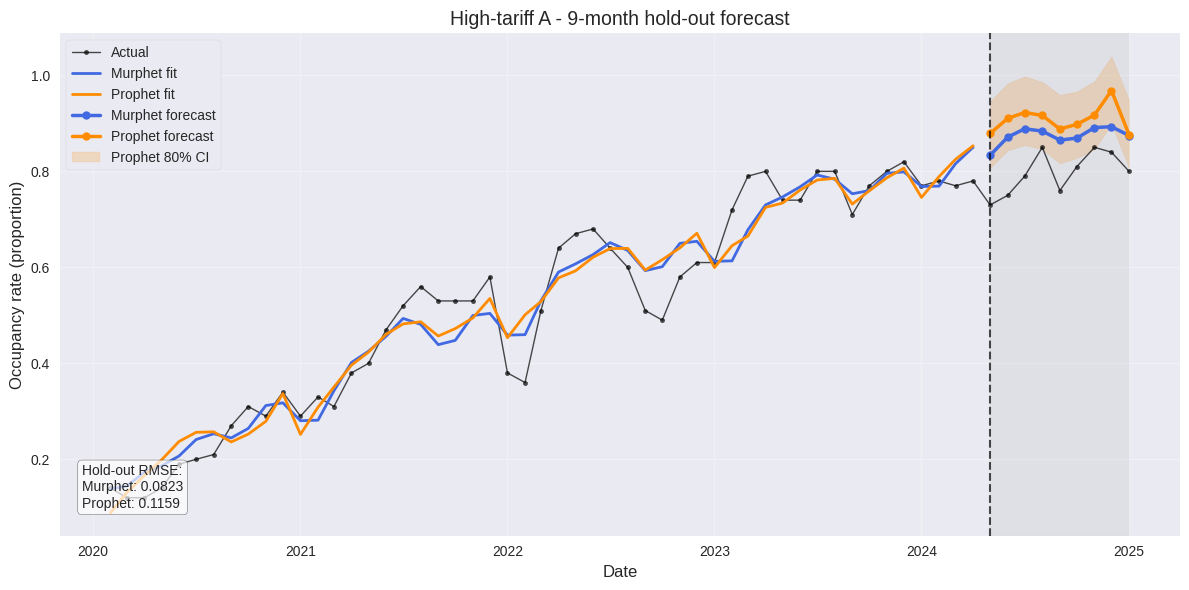

In [10]:

# --- improved visualization -------------------------------------------------
plt.style.use("seaborn-v0_8")
fig, ax = plt.subplots(figsize=(12, 6))  # Increased figure size

# Plot the full series in the background with lower opacity
ax.plot(series["ds"], series["y"], "k.-", lw=1, alpha=0.7, label="Actual")

# Plot model fits with slightly thicker lines
ax.plot(train["ds"], mur_fit.predict(train["t"]),
        color="royalblue", lw=2, label="Murphet fit")
ax.plot(train["ds"],
        prop_fit.predict(train[["ds"]])["yhat"],
        color="darkorange", lw=2, label="Prophet fit")

# Make forecast lines more visible
ax.plot(test["ds"], mur_pred, "o-", color="royalblue", markersize=6,
        lw=2.5, label="Murphet forecast")
ax.plot(test["ds"], prop_pred, "o-", color="darkorange", markersize=6,
        lw=2.5, label="Prophet forecast")

# Better confidence interval
ax.fill_between(test["ds"], prop_low, prop_upp,
                color="darkorange", alpha=0.2, label="Prophet 80% CI")

# Vertical line and improved visuals
ax.axvline(test["ds"].iloc[0], color="k", ls="--", alpha=0.7, lw=1.5)
ax.grid(True, alpha=0.3)
ax.set_title(f"High-tariff A - {HOLD_OUT_MO}-month hold-out forecast", fontsize=14)
ax.set_ylabel("Occupancy rate (proportion)", fontsize=12)
ax.set_xlabel("Date", fontsize=12)

# Better legend
ax.legend(frameon=True, fontsize=10, loc="upper left")
fig.tight_layout()

# Add shaded region for test period
ax.axvspan(test["ds"].iloc[0], test["ds"].iloc[-1], alpha=0.1, color='gray')

# Add RMSE annotation
textstr = f"Hold-out RMSE:\nMurphet: {rmse(test['y'], mur_pred):.4f}\nProphet: {rmse(test['y'], prop_pred):.4f}"
props = dict(boxstyle='round', facecolor='white', alpha=0.7)
ax.text(0.02, 0.05, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='bottom', bbox=props)